# 📊 Model Evaluation Notebook – Fire Detection Project

This notebook evaluates the performance of trained fire classification models on the D-Fire dataset. It is currently set up to evaluate the baseline ResNet-50 model trained on 100% real data, using a hold-out test set composed of unseen real fire and no-fire images.

Over time, this notebook will be extended to evaluate additional models trained on:
- Synthetic-only datasets
- Mixed synthetic-real compositions (25%, 50%, 75%)
- Fine-tuned variants and alternative architectures (if applicable)

## 📌 Current Scope
- Load and evaluate the best-performing ResNet-50 model (trained on real-only data)
- Compute key metrics: Accuracy, Precision, Recall, F1
- Generate confusion matrix and classification report
- Plot ROC curve (if probability scores available)

This notebook assumes the test data has already been preprocessed and structured using the same pipeline as the training data.

---


## 📦 Notebook Setup: Mount Drive & Clone GitHub Repo

This cell ensures the notebook is reproducible in any new Colab session by:

- Mounting your Google Drive (to access datasets, secrets, and checkpoints)
- Loading your GitHub token from Drive
- Cloning the fire-detection-dissertation repository
- Navigating into the correct folder
- Setting Git identity for future commits

⚠️ **Note:** This cell must be run every time you open this notebook in a new Colab session.


In [1]:
# 🔧 Minimal Colab setup for any working notebook

# 1. Mount Google Drive
import os
from google.colab import drive
if not os.path.ismount("/content/drive"):
    drive.mount("/content/drive")

# 2. Load GitHub token securely from Drive
token_path = "/content/drive/MyDrive/fire-detection-dissertation/secrets/github_token.txt"
with open(token_path, "r") as f:
    token = f.read().strip()

# 3. Clone the GitHub repo (force fresh clone for safety)
username = "Misharasapu"
repo = "fire-detection-dissertation"
clone_url = f"https://{token}@github.com/{username}/{repo}.git"
repo_path = f"/content/{repo}"

# Optional: Remove old clone (safe to rerun)
!rm -rf {repo_path}

# Clone fresh and move into the repo
%cd /content
!git clone {clone_url}
%cd {repo}

# 4. Set Git identity (required in Colab sessions)
!git config --global user.name "Misharasapu"
!git config --global user.email "misharasapu@gmail.com"


Mounted at /content/drive
/content
Cloning into 'fire-detection-dissertation'...
remote: Enumerating objects: 44, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 44 (delta 16), reused 32 (delta 8), pack-reused 0 (from 0)
Receiving objects: 100% (44/44), 188.49 KiB | 6.50 MiB/s, done.
Resolving deltas: 100% (16/16), done.
/content/fire-detection-dissertation


## 🧪 Step 1: Load the D-Fire Test Dataset

In this step, we load the hold-out test set from the real D-Fire dataset. The test images and their corresponding YOLO-format `.txt` label files are stored separately under `/MyDrive/fire-detection-dissertation/data/raw/real/D Fire/`.

We use the custom `FireClassificationDataset` class (defined in `utils/fire_classification_dataset.py`) to dynamically pair each image with its label, applying the same preprocessing transform (resize to 224×224 and convert to tensor) as used during training.

This ensures consistency in input shape and format when the test data is passed into the trained ResNet-50 model.


In [2]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from utils.fire_classification_dataset import FireClassificationDataset

# Set paths to test image and label directories
image_dir = "/content/drive/MyDrive/fire-detection-dissertation/data/raw/real/D-Fire/test/images"
label_dir = "/content/drive/MyDrive/fire-detection-dissertation/data/raw/real/D-Fire/test/labels"

# Define preprocessing transforms (same as used during training)
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Create test dataset and DataLoader
test_dataset = FireClassificationDataset(image_dir=image_dir, label_dir=label_dir, transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

print(f"✅ Test set loaded successfully with {len(test_dataset)} samples.")


✅ Test set loaded successfully with 4306 samples.


## 🧠 Step 2: Load the Trained ResNet-50 Model

In this step, we load the best-performing model checkpoint saved during training on 100% real data from the D-Fire dataset. The model is based on ResNet-50 with all pretrained layers frozen, except for the final fully connected (FC) layer which was retrained for binary classification.

The checkpoint file `resnet_real_100.pt` was saved in the `/models/` directory and contains the weights of the best model selected based on F1 score during validation. We restore these weights into a fresh ResNet-50 architecture and move the model to the GPU for evaluation.


In [3]:
import torch
import torch.nn as nn
import torchvision.models as models

# Select device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔌 Using device: {device}")

# Load a fresh ResNet-50 model (not pretrained since we'll load our own weights)
model = models.resnet50(pretrained=False)

# Replace final FC layer with 2-class output layer (fire vs no fire)
model.fc = nn.Linear(model.fc.in_features, 2)

# Load trained weights from checkpoint
checkpoint_path = "/content/drive/MyDrive/fire-detection-dissertation/models/resnet_real_100.pt"
model.load_state_dict(torch.load(checkpoint_path, map_location=device))

# Move model to GPU/CPU and set to evaluation mode
model = model.to(device)
model.eval()

print("✅ Model loaded and ready for evaluation.")


🔌 Using device: cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


✅ Model loaded and ready for evaluation.


## 📈 Step 3: Evaluate Model on Hold-Out Test Set

In this step, we use the trained ResNet-50 model to make predictions on the unseen D-Fire test set. We compare its predictions against ground-truth labels to compute core classification metrics:

- Accuracy
- Precision
- Recall
- F1 Score

We use the `calculate_metrics()` helper function (from `utils/metrics.py`) to ensure consistent metric computation throughout the project. No gradients are computed during this step, and the model remains in evaluation mode to prevent any parameter updates.


In [4]:
from utils.metrics import calculate_metrics

y_true = []
y_pred = []

# Disable gradient computation for inference
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Convert predictions to tensors for metric calculation
y_true_tensor = torch.tensor(y_true)
y_pred_tensor = torch.tensor(y_pred)

# Compute and print evaluation metrics
metrics = calculate_metrics(y_true_tensor, y_pred_tensor)

print("\n📊 Evaluation Results on Test Set:")
print(f"Accuracy : {metrics['accuracy']:.4f}")
print(f"Precision: {metrics['precision']:.4f}")
print(f"Recall   : {metrics['recall']:.4f}")
print(f"F1 Score : {metrics['f1']:.4f}")



📊 Evaluation Results on Test Set:
Accuracy : 0.9264
Precision: 0.8874
Recall   : 0.8197
F1 Score : 0.8522


## 🧮 Step 4: Confusion Matrix and Classification Report

Now that we’ve computed the overall metrics, we generate a confusion matrix to visualise the distribution of true vs predicted labels. This shows us how many fire and non-fire images were correctly and incorrectly classified.

We also print the full classification report from `scikit-learn`, which includes:
- Precision, Recall, and F1 score **per class**
- Class support (i.e., number of samples per class in the test set)

These tools are especially useful for understanding imbalanced datasets or identifying which class the model struggles with.


✅ Confusion matrix saved to: /content/drive/MyDrive/fire-detection-dissertation/figures/confusion_matrices/resnet_real_100.png


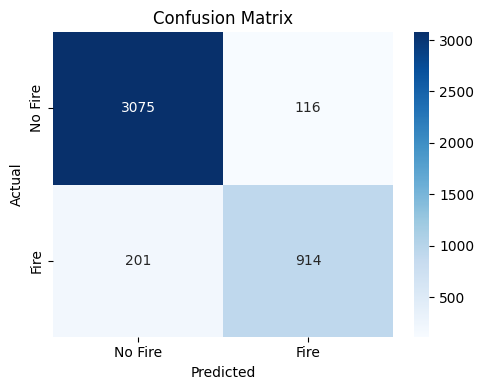


📝 Classification Report:
              precision    recall  f1-score   support

     No Fire       0.94      0.96      0.95      3191
        Fire       0.89      0.82      0.85      1115

    accuracy                           0.93      4306
   macro avg       0.91      0.89      0.90      4306
weighted avg       0.93      0.93      0.93      4306



In [13]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot and save confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Fire", "Fire"],
            yticklabels=["No Fire", "Fire"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()

# 🔽 Save before plt.show()
cm_path = "/content/drive/MyDrive/fire-detection-dissertation/figures/confusion_matrices/resnet_real_100.png"
plt.savefig(cm_path)
print(f"✅ Confusion matrix saved to: {cm_path}")

plt.show()

# Print classification report
print("\n📝 Classification Report:")
print(classification_report(y_true, y_pred, target_names=["No Fire", "Fire"]))


## 📉 Step 5: ROC Curve and AUC Score

In this step, we evaluate how well the model separates fire vs no-fire classes across different thresholds by plotting the Receiver Operating Characteristic (ROC) curve.

- The ROC curve shows the trade-off between **True Positive Rate** (Recall) and **False Positive Rate** at different classification thresholds.
- The **AUC score** (Area Under Curve) summarizes the model's ability to distinguish between classes. AUC = 1 means perfect classification; 0.5 means random guessing.

We use the softmax probabilities of the "fire" class (class 1) to compute this.


✅ ROC curve saved to: /content/drive/MyDrive/fire-detection-dissertation/figures/roc_curves/resnet_real_100.png


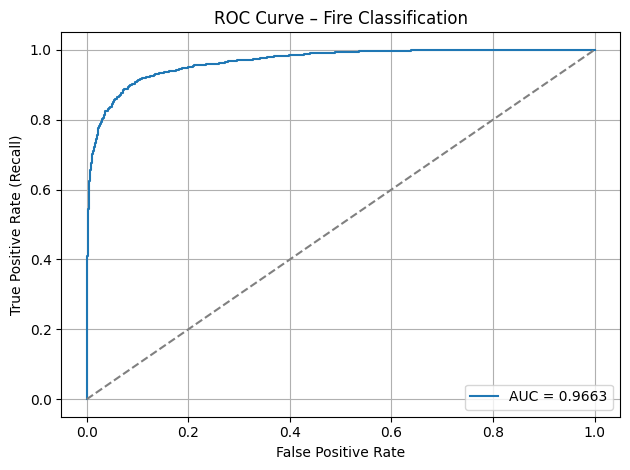

In [14]:
from sklearn.metrics import roc_curve, roc_auc_score
from torch.nn.functional import softmax
import matplotlib.pyplot as plt

# Collect probabilities of class 1 ("Fire")
y_probs = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        probs = softmax(outputs, dim=1)[:, 1]  # Probability of class 1
        y_probs.extend(probs.cpu().numpy())

# Compute ROC curve and AUC score
fpr, tpr, _ = roc_curve(y_true, y_probs)
auc_score = roc_auc_score(y_true, y_probs)

# Plot and save ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Random baseline
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve – Fire Classification")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()

# 🔽 Save before show
roc_path = "/content/drive/MyDrive/fire-detection-dissertation/figures/roc_curves/resnet_real_100.png"
plt.savefig(roc_path)
print(f"✅ ROC curve saved to: {roc_path}")

plt.show()


In [10]:
# Save metrics to results/metrics/
results_str = (
    "📊 Evaluation Results for Model: resnet_real_100\n"
    "---------------------------------------------\n"
    f"Accuracy : {metrics['accuracy']:.4f}\n"
    f"Precision: {metrics['precision']:.4f}\n"
    f"Recall   : {metrics['recall']:.4f}\n"
    f"F1 Score : {metrics['f1']:.4f}\n"
    f"AUC      : {auc_score:.4f}\n"
)

metrics_file = "/content/drive/MyDrive/fire-detection-dissertation/results/metrics/resnet_real_100.txt"
with open(metrics_file, "w") as f:
    f.write(results_str)

print(f"✅ Metrics saved to: {metrics_file}")


✅ Metrics saved to: /content/drive/MyDrive/fire-detection-dissertation/results/metrics/resnet_real_100.txt


In [ ]:
%cd /content/fire-detection-dissertation
